In [1]:
# Modules imported

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, cross_val_score, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
import joblib

In [2]:
# Functions Used

from zlib import crc32

#------------------------------------------------------------------------

def train_test_split_by_shuffling(data, test_ratio):
  '''It takes Data and Test Ratio as it's parameters where,
  Data : Dataset which you want to split.
  Train Ratio : Ratio of data you want to have in Test dataset compared to train dataset

  Return : It returns two datasets where one will be train_dataset(1-test_ratio) and test_dataset(test_ratio).'''
  np.random.seed(42) # it will make sure the results are reproducible
  shuffled_indices = np.random.permutation(len(data)) # it gives us vector contaning index from 0 to len(data) randomly placed
  test_set_size = int(len(data) * test_ratio) # this gives us the number of data points we want in our test set
  test_indices = shuffled_indices[:test_set_size] # this will give us a vector with the number of items(indices) needed by us to be in test_set
  train_indices = shuffled_indices[test_set_size:] # this will get us a vector containing the rest of items(indices)
  # now we will use these indices to select the data points for train and test set respec. using iloc[] on data which will give us two datasets one containing data point whose indices were in the train_indices and other whose was in test_indices
  return data.iloc[train_indices], data.iloc[test_indices]


# -----------------------------------------------------------------------

def test_set_check(identifier, test_ratio):
  '''It takes a unique identifier of any dataset and Test Ratio as parameters where,
  Identifier : Any columns which can be used to uniquely identify each instance of a dataset
  Test Ratio : Ratio of data you want to have in Test dataset compared to train dataset

  Return : It return a boolean mask with 'True' where the id's hash is less than test_ratio * np.power(2, 32) and 'Flase' otherwise.'''
  return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * np.power(2, 32)

def train_test_slpit_by_id(data, identifier, test_ratio):
  '''It takes Data, Identifier Column and Test Ratio as it's parameters where,
  Data : Dataset which you want to split.
  Identifier : Any columns which can be used to uniquely identify each instance of a dataset
  Train Ratio : Ratio of data you want to have in Test dataset compared to train dataset

  Return : It returns two datasets where one will be train_dataset(thats not in test_ratio) and test_dataset(falls within test_ratio).'''

  ids = data[identifier]
  is_in_test = ids.apply(lambda idn : test_set_check(idn, test_ratio))
  return data.loc[~is_in_test], data.loc[is_in_test]

In [3]:
housing = pd.read_csv('/Jupyter/Temp/California Book Data/housing.csv')
housing.head(3)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY


In [4]:
print(housing.info())
print()
housing.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB
None



,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


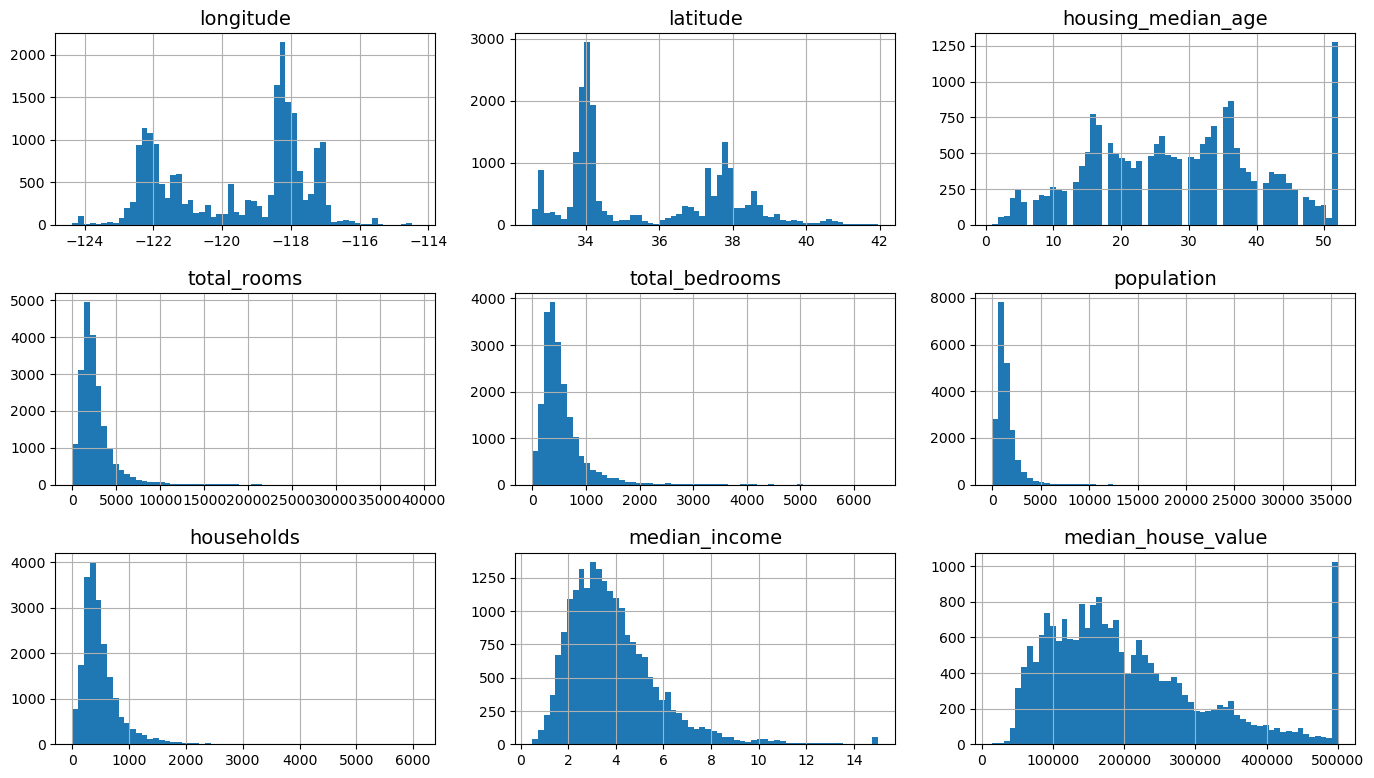

In [5]:
# %matplotlib qt # can be used to produce output in a seperate window
# extra code – the next 5 lines define the default font sizes
# here we are using the rc function to set various properties default value or change their default values to some desired values (can also use rcParmas which is a dictionary for these properties)
# it follows the following pattern rc('artist_we_want_modify', property_or_parameter_you_want_to_change)
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

housing.hist(bins=60, figsize=(14, 8))
plt.tight_layout()
plt.show()

In [6]:
train_data, test_data = train_test_split_by_shuffling(housing, .20)
train_data.shape, test_data.shape

((16512, 10), (4128, 10))

In [7]:
train_cal, test_cal = train_test_split(housing, test_size = .20, random_state = 42)
train_cal.shape, test_cal.shape

((16512, 10), (4128, 10))

In [8]:
housing_with_id = housing.copy()
housing_with_id['id'] = housing.longitude * 100 + housing.latitude
train, test = train_test_slpit_by_id(housing_with_id, 'id', .20)
train.shape, test.shape

((16406, 11), (4234, 11))

In [9]:
# Train-Test stratified split

housing['income_cat'] = pd.cut(housing['median_income'], bins = [0.0, 1.5, 3.0, 4.5, 6.0, np.inf], labels = [1, 2, 3, 4, 5])
# this will create a new column by cutting an existing column which will have five values stated in labels parm which in turn will have values in range stated in bins parm i.e. label '1' will be assigned to data points on new column where the old column have value in range 0.0 to 1.5 label '2' to points were original col have 1.5 to 3.0 and so on.

splitter = StratifiedShuffleSplit(n_splits = 1, test_size = .20, random_state = 42) # this will create an object of StratifedShuffleSplit which will spilt the data once with test set being 20% of all data.

# then we will use split() function of the class StratifedShuffleSplit using the obj of the same class we just created by passing it the dataset and the column based on which this split will be performed i.e. it will make sure that if 10% of data in the give column fall in label '1' then 10% of data in train set as well as test set will also be of label '1'

for train_index, test_index in splitter.split(housing, housing.income_cat): # we use for loop as this func can be used to split multiple times which will give us multiple train-test index so to handle these multiple values we use for loop however in over case n_split = 1 so we don't necessarily need it
  # then we use these indices to get the train-test sets
  stratified_train_housing = housing.iloc[train_index]
  stratified_test_housing = housing.iloc[test_index]


# as we only need to performe one split we can instead use inbuilt train_test_split()
stratified_train_housing, stratified_test_housing = train_test_split(housing, test_size = .20, random_state = 42, stratify = housing['income_cat'])

# as after the split index of dataframe will be unordered so to make it ordered again we reset it's index
stratified_train_housing.reset_index(drop = True, inplace = True)
stratified_test_housing.reset_index(drop = True, inplace = True)

# now as we are done with samplling we can safely drop the column 'income_cat' we created as it's not a real feature, it doesn't offer anything new to the model
for set_ in (stratified_train_housing, stratified_test_housing):
  set_.drop('income_cat', inplace = True, axis = 1)

stratified_train_housing.shape, stratified_test_housing.shape

((16512, 10), (4128, 10))

<Axes: xlabel='Longitude', ylabel='Latitude'>

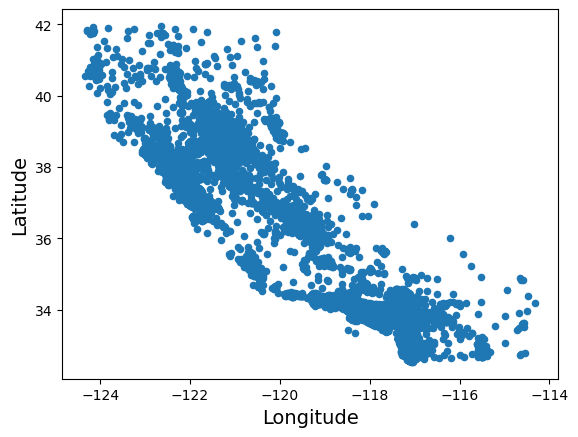

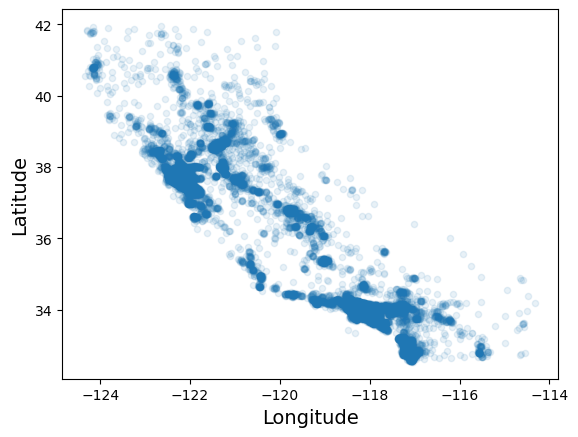

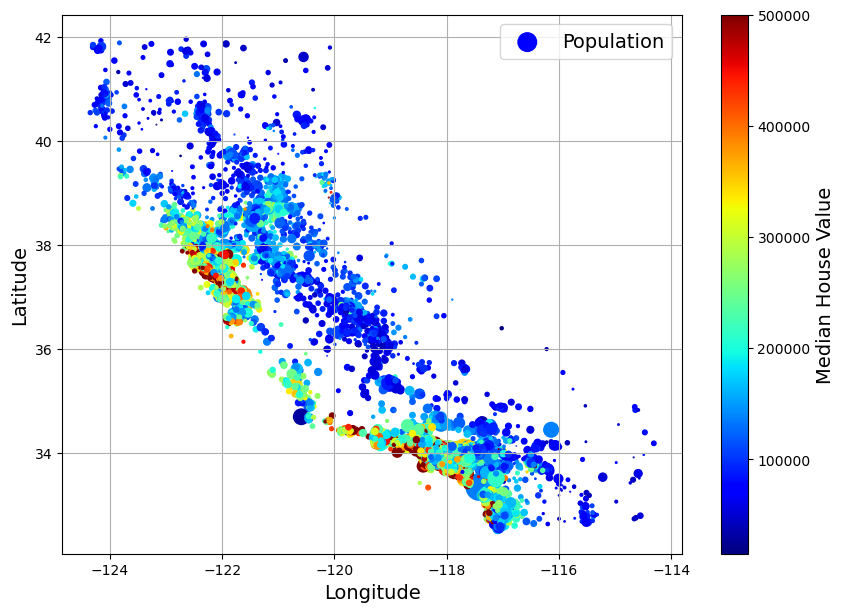

In [10]:
# Longitude-Latitude Graph

explore_housing = stratified_train_housing.copy()
explore_housing.rename(columns = {
                        'latitude' : 'Latitude',
                        'longitude' : 'Longitude',
                        'housing_median_age': 'Housing Median Age',
                        'total_rooms' : 'Total Rooms',
                        'total_bedrooms' : 'Total Bedrooms',
                        'population' : 'Population',
                        'households' : 'Households',
                        'median_income' : 'Median Income',
                        'median_house_value' : 'Median House Value',
                        'ocean_proximity' : 'Ocean Proximity'},
                         inplace = True)


explore_housing.plot(kind = 'scatter', x = 'Longitude', y = 'Latitude')

explore_housing.plot(kind = 'scatter', x = 'Longitude', y = 'Latitude', alpha = .1)

explore_housing.plot(
  kind = 'scatter', # it tells what kind of plot to draw
  x = 'Longitude', # value for x-axis
  y = 'Latitude', # value for y-axis
  grid = True, # it define the transparency of plot elements/points
  s = explore_housing['Population'] / 100, # size of the points will depend on it's value
  label = 'Population',
  c = 'Median House Value', # color of the point will depend on it's value,
  # sharex = False, # it is used t ostate weather the x-axis is shared by multiple subplots or not
  legend = True,
  cmap = 'jet', # a pre-defined color map (blue to red)
  figsize = (10,7))

In [11]:
corr_matrix = explore_housing.corr(numeric_only = True)
corr_matrix['Median House Value'].sort_values()

Latitude             -0.142673
Longitude            -0.047466
Population           -0.026882
Total Bedrooms        0.047781
Households            0.064590
Housing Median Age    0.114146
Total Rooms           0.135140
Median Income         0.687151
Median House Value    1.000000
Name: Median House Value, dtype: float64

array([[<Axes: xlabel='Median House Value', ylabel='Median House Value'>,
        <Axes: xlabel='Median Income', ylabel='Median House Value'>,
        <Axes: xlabel='Total Rooms', ylabel='Median House Value'>,
        <Axes: xlabel='Housing Median Age', ylabel='Median House Value'>],
       [<Axes: xlabel='Median House Value', ylabel='Median Income'>,
        <Axes: xlabel='Median Income', ylabel='Median Income'>,
        <Axes: xlabel='Total Rooms', ylabel='Median Income'>,
        <Axes: xlabel='Housing Median Age', ylabel='Median Income'>],
       [<Axes: xlabel='Median House Value', ylabel='Total Rooms'>,
        <Axes: xlabel='Median Income', ylabel='Total Rooms'>,
        <Axes: xlabel='Total Rooms', ylabel='Total Rooms'>,
        <Axes: xlabel='Housing Median Age', ylabel='Total Rooms'>],
       [<Axes: xlabel='Median House Value', ylabel='Housing Median Age'>,
        <Axes: xlabel='Median Income', ylabel='Housing Median Age'>,
        <Axes: xlabel='Total Rooms', ylabel='Housi

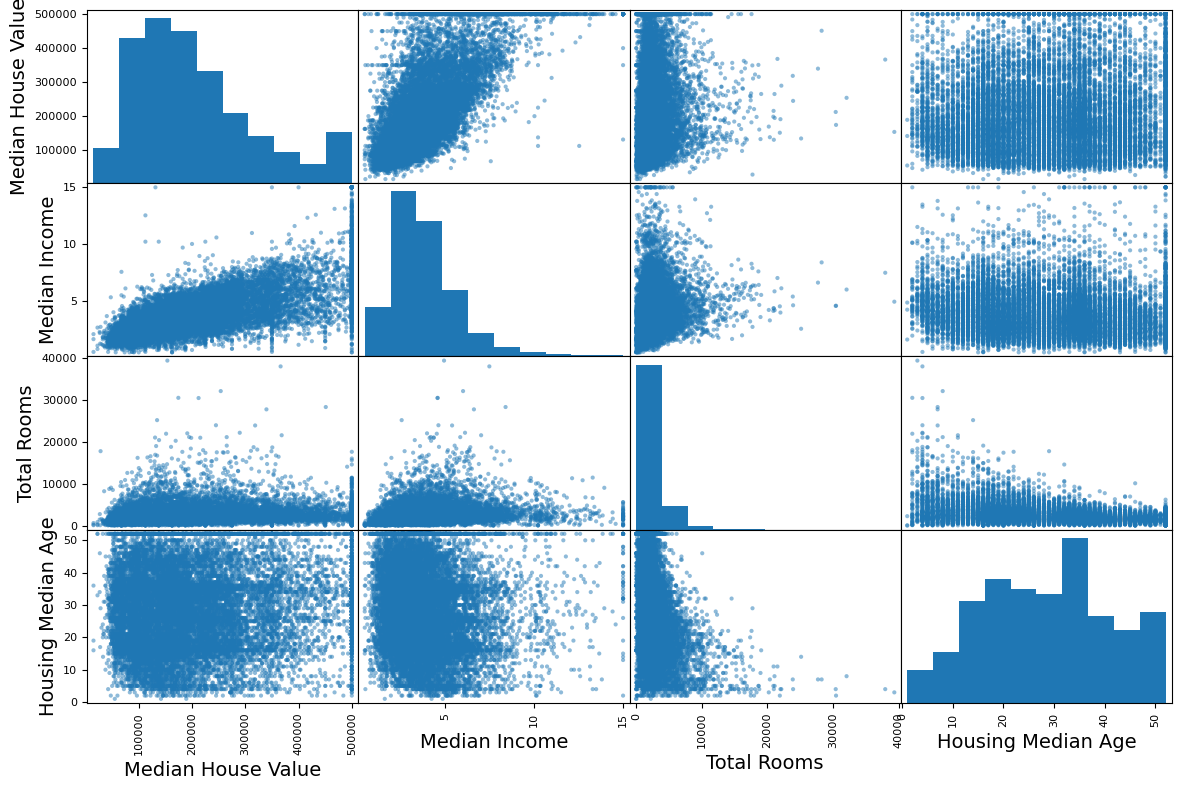

In [12]:
attr_for_scatter_matrix = ['Median House Value', 'Median Income', 'Total Rooms', 'Housing Median Age']
pd.plotting.scatter_matrix(explore_housing[attr_for_scatter_matrix], figsize =  (14,9))

<Axes: xlabel='Median Income', ylabel='Median House Value'>

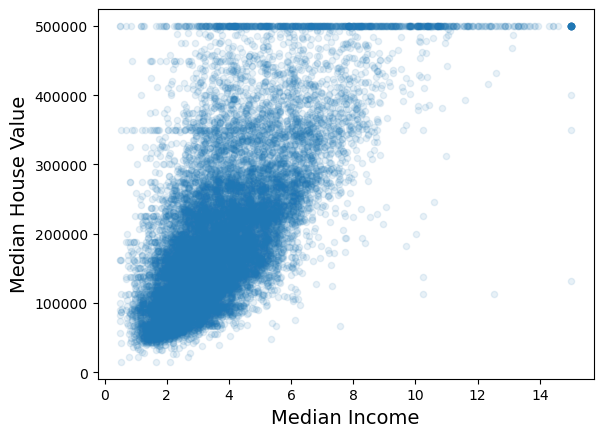

In [13]:
explore_housing.plot(kind = 'scatter', x = 'Median Income', y = 'Median House Value', alpha = .1)
# here we can see not only there is a strong positive correlation b/w x and y but can also see the cap of 500k we previously noticed and other than at 500k there are horizontal lines at 350k, 280k, and few other.

In [14]:
explore_housing['Room Per Household'] = explore_housing['Total Rooms'] / explore_housing['Households']
explore_housing['BedRoom Per Room'] = explore_housing['Total Bedrooms'] / explore_housing['Total Rooms']
explore_housing['Pop Per Household'] = explore_housing['Population'] / explore_housing['Households']

corr_matrix = explore_housing.corr(numeric_only = True)
corr_matrix['Median House Value'].sort_values()

# here we can see that 'Bedroom Per Rooms' has much better correlation than bot Total Rooms or BedRooms and so is 'Room Per Household' 'Pop Per Household' not so much.

# this initial exploration doesn't have to be perfect this is an iterative step which will be repeated again and again first time is needed to build a prototype and after that we analyze it's output and explore again.

BedRoom Per Room     -0.259952
Latitude             -0.142673
Longitude            -0.047466
Population           -0.026882
Pop Per Household    -0.021991
Total Bedrooms        0.047781
Households            0.064590
Housing Median Age    0.114146
Total Rooms           0.135140
Room Per Household    0.146255
Median Income         0.687151
Median House Value    1.000000
Name: Median House Value, dtype: float64

In [15]:
# now we will again copy the stratified_train_housing dataframe to get a clean training set and also seperate predictors and target variable as we don't want to apply same transformation to both.
housing_train = stratified_train_housing.drop('median_house_value', axis = 1)
housing_train_labels = stratified_train_housing['median_house_value'].copy()

In [16]:
imputer_obj = SimpleImputer(strategy = 'median') # here we are creating an object of SimpleImputer class and the parameters given to it other than the dataset itself are called hyperparameter and is assigned to an instance variablre which we can access using class instance i.e. imputer_obj.strategy will give 'median' as output

print(imputer_obj.strategy) # like this will give us strategy we are using

imputer_obj.fit(housing_train.select_dtypes('number')) # here we pass the dataset as parameter to the called function fit() which will performe some estimations of datasets parameters and store those values in public instance variables with underscore suffix

print(imputer_obj.statistics_) # like this will give us median of each attribute

housing_train_imputed = imputer_obj.transform(housing_train.select_dtypes('number')) # here we transforme the dataset based off of learned parameters during fit() function call, we can also use fit_transforme() which will do the work of both functions efficently.

housing_train_imputed_df = pd.DataFrame(housing_train_imputed, columns = housing_train.select_dtypes('number').columns, index = housing_train.index) # now as the transforme() gives us an Numpy array we can to convert it to a DataFrame if need be

housing_train_imputed_df.info()

median
[-118.51      34.26      29.      2119.       433.      1164.
  408.         3.54155]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16512 entries, 0 to 16511
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16512 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
dtypes: float64(8)
memory usage: 1.0 MB


In [17]:
housing_category = housing_train[['ocean_proximity']]

ordinal_enc_obj = OrdinalEncoder() # here we are creating an object of OrdinalEncoder() class
one_hot_obj = OneHotEncoder() # here we are creating an object of OneHotEncoder() class

ordinal_enc = ordinal_enc_obj.fit_transform(housing_category) # then we use that object to call fit_transform() on our data which first performe fit() operation and then transform() and will return an array of encoded columns for each catagorical column in our data and since we only have one it gives us a list containg sigle array

one_hot_enc = one_hot_obj.fit_transform(housing_category) # this will give us a sparse matrix which instead of storing all the values it only store nonzero values which is very useful in this case as we are going to have a lot of zeros when using one-hot encoding

In [18]:
print(ordinal_enc_obj.categories_, one_hot_obj.categories_)
# simillar to before we can access the values which it uses for estimation or transformation using instace variables suffixed by underscore
print()
print(housing_category.head(10))
print()
print(ordinal_enc[:10])
print()
print(one_hot_enc)
print()
print(one_hot_enc.toarray())

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
      dtype=object)] [array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
      dtype=object)]

  ocean_proximity
0          INLAND
1      NEAR OCEAN
2          INLAND
3      NEAR OCEAN
4       <1H OCEAN
5        NEAR BAY
6       <1H OCEAN
7       <1H OCEAN
8       <1H OCEAN
9       <1H OCEAN

[[1.]
 [4.]
 [1.]
 [4.]
 [0.]
 [3.]
 [0.]
 [0.]
 [0.]
 [0.]]

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 16512 stored elements and shape (16512, 5)>
  Coords	Values
  (0, 1)	1.0
  (1, 4)	1.0
  (2, 1)	1.0
  (3, 4)	1.0
  (4, 0)	1.0
  (5, 3)	1.0
  (6, 0)	1.0
  (7, 0)	1.0
  (8, 0)	1.0
  (9, 0)	1.0
  (10, 1)	1.0
  (11, 0)	1.0
  (12, 1)	1.0
  (13, 1)	1.0
  (14, 4)	1.0
  (15, 0)	1.0
  (16, 0)	1.0
  (17, 0)	1.0
  (18, 3)	1.0
  (19, 0)	1.0
  (20, 1)	1.0
  (21, 3)	1.0
  (22, 1)	1.0
  (23, 0)	1.0
  (24, 1)	1.0
  :	:
  (16487, 1)	1.0
  (16488, 0)	1.0
  (16489, 4)	1.0
  (16490, 4)	1.0
  (16491, 1)	1.0
  (1649

In [19]:
dict(Y=[[35.]], gamma=0.1)

{'Y': [[35.0]], 'gamma': 0.1}

### Some other classes providede by SciKit Learn are:
- **Function Transformer**

  Used to form a custom transformer to use in a Pipeline where the transformer uses a function to transform the given data.

- **TransformedTargetRegressor**

  Used to transforme the target variable according to any transformer and the performe the estimations and return the result in original scale.

In [20]:
from sklearn.utils.validation import check_array, check_is_fitted

In [21]:
# Custom Classes used

rooms_in, bedroom_in, pop_in, household_in = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
  def __init__(self, add_bedrooms_per_room = True):
    self.add_bedrooms_per_room = add_bedrooms_per_room

  def fit(self, X, y = None):
    # X = check_array(X) # verify whether passed data is an array or not can also apply various other constraints to it all stated in check_array
    # self.is_fitted_ = True
    return self

  def transform(self, X):
    # check_is_fitted(self, 'is_fitted_') # verify wheteher the fit has already been called or not
    room_per_household = X[:, rooms_in] / X[:, household_in]
    pop_per_household = X[:, pop_in] / X[:, household_in]
    if self.add_bedrooms_per_room:
      bedroom_per_rooms = X[:, bedroom_in] / X[:, rooms_in]
      return np.c_[X, room_per_household, pop_per_household, bedroom_per_rooms] # np.c_ concatenate new features column wise
    else:
      return np.c_[X, room_per_household, pop_per_household]

In [22]:
# Class Check
combine_att = CombinedAttributesAdder(add_bedrooms_per_room = False)
with_add_attr = combine_att.fit_transform(housing_train.values)
pd.DataFrame(with_add_attr)

,0,1,2,3,4,5,6,7,8,9,10
0,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,INLAND,5.485836,3.168555
1,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,NEAR OCEAN,6.927083,2.623698
2,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.875,INLAND,5.393333,2.223333
3,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,NEAR OCEAN,3.886128,1.859213
4,-118.7,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,<1H OCEAN,6.096552,3.167241
...,...,...,...,...,...,...,...,...,...,...,...
16507,-117.07,33.03,14.0,6665.0,1231.0,2026.0,1001.0,5.09,<1H OCEAN,6.658342,2.023976
16508,-121.42,38.51,15.0,7901.0,1422.0,4769.0,1418.0,2.8139,INLAND,5.571932,3.363188
16509,-122.72,38.44,48.0,707.0,166.0,458.0,172.0,3.1797,<1H OCEAN,4.110465,2.662791
16510,-122.7,38.31,14.0,3155.0,580.0,1208.0,501.0,4.1964,<1H OCEAN,6.297405,2.411178


In [23]:
# Pipeline

num_pipeline = Pipeline([
  ('imputer', SimpleImputer(strategy = 'median')),
  ('att_add', CombinedAttributesAdder()),
  ('std_scaler', StandardScaler())])

category_pipeline = Pipeline([
  ('encoder', OneHotEncoder(handle_unknown = 'ignore'))])

num_attributes = housing_train.select_dtypes(include = 'number').columns.tolist()
cat_attributes = housing_train.select_dtypes(exclude = 'number').columns.tolist()

full_pipeline = ColumnTransformer([
  ('num_pip', num_pipeline, num_attributes),
  ('cat_pip', category_pipeline, cat_attributes)])

pipline_cal_data = full_pipeline.fit_transform(housing_train)

# adding column names---------------------------------------------------
added_num_att = ['rooms_per_household', 'population_per_household']
if num_pipeline.named_steps['att_add'].add_bedrooms_per_room:
  added_num_att.append('bedrooms_per_room')

num_base_att = housing_train.select_dtypes(include = 'number').columns.tolist()
num_att_final = num_base_att + added_num_att

cat_encoder = full_pipeline.named_transformers_['cat_pip'].named_steps['encoder']
cat_att = cat_encoder.get_feature_names_out().tolist()

all_attribs = list(num_att_final + cat_att)

housing_pre_processed = pd.DataFrame(pipline_cal_data, columns = all_attribs, index = housing_train.index)

In [24]:
# LinearRegression

lr_model = LinearRegression()
lr_model.fit(housing_pre_processed, housing_train_labels)

# Sanity Check----------------------------------------------------------
some_data = housing_train.iloc[:5]
some_data_labels = housing_train_labels.iloc[:5]
some_data_for_pred = full_pipeline.transform(some_data)
lr_predictions = lr_model.predict(some_data_for_pred)
print(pd.DataFrame({
    'Predicted': lr_predictions,
    'Actual': some_data_labels.values,
    'Error' : ((lr_predictions - some_data_labels.values) / some_data_labels.values) * 100
}).round(2))
# ----------------------------------------------------------------------

lin_housing_pred = lr_model.predict(housing_pre_processed)
lin_mse = mean_squared_error(housing_train_labels, lin_housing_pred)
lin_rmse = np.sqrt(lin_mse)
print('RMSE : ',lin_rmse)

# Cross-Validation------------------------------------------------------
lin_score = cross_val_score(lr_model, housing_pre_processed, housing_train_labels, cv = 10, scoring = 'neg_mean_squared_error')
lin_rmse = np.sqrt(-lin_score)
lin_rmse, lin_rmse.mean(), lin_rmse.std()

   Predicted    Actual  Error
0   85657.90   72100.0  18.80
1  305492.61  279600.0   9.26
2  152056.46   82700.0  83.87
3  186095.71  112500.0  65.42
4  244550.68  238300.0   2.62
RMSE :  68627.87390018745


E:\miniconda3\envs\AI_ML\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


(array([71762.76364394, 64114.99166359, 67771.17124356, 68635.19072082,
        66846.14089488, 72528.03725385, 73997.08050233, 68802.33629334,
        66443.28836884, 70139.79923956]),
 np.float64(69104.07998247063),
 np.float64(2880.32820981806))

In [25]:
# DecisionTreeRegressor

dt_model = DecisionTreeRegressor()
dt_model.fit(housing_pre_processed, housing_train_labels)

# Sanity Check----------------------------------------------------------
dt_predictions = dt_model.predict(some_data_for_pred)
print(pd.DataFrame({
    'Predicted': dt_predictions,
    'Actual': some_data_labels.values,
    'Error' : ((dt_predictions - some_data_labels.values) / some_data_labels.values) * 100
}).round(2))
# ----------------------------------------------------------------------

dt_housing_pred = dt_model.predict(housing_pre_processed)
dt_mse = mean_squared_error(housing_train_labels, dt_housing_pred)
dt_rmse = np.sqrt(dt_mse)
print('RMSE : ', dt_rmse)

# Cross-Validation------------------------------------------------------
dt_score = cross_val_score(dt_model, housing_pre_processed, housing_train_labels, cv = 10, scoring = 'neg_mean_squared_error')
dt_rmse = np.sqrt(-dt_score)
dt_rmse, dt_rmse.mean(), dt_rmse.std()

E:\miniconda3\envs\AI_ML\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


   Predicted    Actual  Error
0    72100.0   72100.0    0.0
1   279600.0  279600.0    0.0
2    82700.0   82700.0    0.0
3   112500.0  112500.0    0.0
4   238300.0  238300.0    0.0
RMSE :  0.0


(array([72251.22610062, 70811.34799853, 68000.08591434, 71929.39104752,
        69328.61392367, 77963.99482744, 71628.79228943, 73511.78648072,
        69045.58722762, 69854.4073967 ]),
 np.float64(71432.52332065887),
 np.float64(2696.6824522410743))

In [26]:
# RandomForestRegressor

rf_model = RandomForestRegressor()
rf_model.fit(housing_pre_processed, housing_train_labels)

# Sanity Check----------------------------------------------------------
rf_predictions = rf_model.predict(some_data_for_pred)
print(pd.DataFrame({
    'Predicted': rf_predictions,
    'Actual': some_data_labels.values,
    'Error' : ((rf_predictions - some_data_labels.values) / some_data_labels.values) * 100
}).round(2))
# ----------------------------------------------------------------------

rf_housing_pred = rf_model.predict(housing_pre_processed)
rf_mse = mean_squared_error(housing_train_labels, rf_housing_pred)
rf_rmse = np.sqrt(rf_mse)
print('RMSE : ', rf_rmse)

# Cross-Validation------------------------------------------------------
rf_score = cross_val_score(rf_model, housing_pre_processed, housing_train_labels, cv = 10, scoring = 'neg_mean_squared_error')
rf_rmse = np.sqrt(-rf_score)
rf_rmse, rf_rmse.mean(), rf_rmse.std()

E:\miniconda3\envs\AI_ML\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


   Predicted    Actual  Error
0    73532.0   72100.0   1.99
1   292499.0  279600.0   4.61
2    81425.0   82700.0  -1.54
3   124139.0  112500.0  10.35
4   227960.0  238300.0  -4.34
RMSE :  18733.78842762556


(array([51340.22553753, 49240.079874  , 46976.40445657, 51917.1921677 ,
        47035.53338226, 51829.80557131, 52841.15437862, 49525.18429381,
        47962.29506428, 54069.20606905]),
 np.float64(50273.7080795117),
 np.float64(2357.685647654302))

In [27]:
# Support Vector Regressor

svr_model = SVR()
svr_model.fit(housing_pre_processed, housing_train_labels)

# Sanity Check----------------------------------------------------------
svr_predictions = svr_model.predict(some_data_for_pred)
print(pd.DataFrame({
    'Predicted': svr_predictions,
    'Actual': some_data_labels.values,
    'Error' : ((svr_predictions - some_data_labels.values) / some_data_labels.values) * 100
}).round(2))
# ----------------------------------------------------------------------

svr_housing_pred = svr_model.predict(housing_pre_processed)
svr_mse = mean_squared_error(housing_train_labels, svr_housing_pred)
svr_rmse = np.sqrt(svr_mse)
print('RMSE : ', svr_rmse)

# Cross Validation------------------------------------------------------
svr_score = cross_val_score(svr_model, housing_pre_processed, housing_train_labels, cv = 10, scoring = 'neg_mean_squared_error')
svr_rmse = np.sqrt(-svr_score)
svr_rmse, svr_rmse.mean(), svr_rmse.std()

E:\miniconda3\envs\AI_ML\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


   Predicted    Actual   Error
0  178735.53   72100.0  147.90
1  180008.05  279600.0  -35.62
2  178900.88   82700.0  116.33
3  178924.11  112500.0   59.04
4  179998.98  238300.0  -24.47
RMSE :  118578.69234925653


(array([116729.13778306, 120113.99351281, 113925.04340616, 120399.11878641,
        114687.49942071, 122785.64737282, 119853.79338279, 118280.31108193,
        120230.82615529, 118840.1885232 ]),
 np.float64(118584.55594251942),
 np.float64(2609.6120823493407))

In [28]:
# GradientBoostingRegressor

gbr_model = GradientBoostingRegressor()
gbr_model.fit(housing_pre_processed, housing_train_labels)

# Sanity Check----------------------------------------------------------
gbr_predictions = gbr_model.predict(some_data_for_pred)
print(pd.DataFrame({
    'Predicted': gbr_predictions,
    'Actual': some_data_labels.values,
    'Error' : ((gbr_predictions - some_data_labels.values) / some_data_labels.values) * 100
}).round(2))
# ----------------------------------------------------------------------

gbr_housing_pred = gbr_model.predict(housing_pre_processed)
gbr_mse = mean_squared_error(housing_train_labels, gbr_housing_pred)
gbr_rmse = np.sqrt(gbr_mse)
print('RMSE : ', gbr_rmse)

# Cross-Validation------------------------------------------------------
scores = cross_val_score(gbr_model, housing_pre_processed, housing_train_labels, cv = 10, scoring = 'neg_mean_squared_error')
gbr_rmse = np.sqrt(-scores)
gbr_rmse, gbr_rmse.mean(), gbr_rmse.std()

E:\miniconda3\envs\AI_ML\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(


   Predicted    Actual  Error
0   83513.75   72100.0  15.83
1  322449.77  279600.0  15.33
2   99825.39   82700.0  20.71
3  168937.12  112500.0  50.17
4  214737.85  238300.0  -9.89
RMSE :  50651.5088944892


(array([54570.66192762, 51218.74606634, 49290.42846021, 55792.37780972,
        50913.72551572, 53331.4585896 , 54948.34284478, 53325.1615811 ,
        50888.97975466, 55911.60636741]),
 np.float64(53019.148891717),
 np.float64(2202.101417681784))

In [29]:
# KNeighborsRegressor

knr_model = KNeighborsRegressor()
knr_model.fit(housing_pre_processed, housing_train_labels)

# Sanity Check----------------------------------------------------------
knr_predictions = knr_model.predict(some_data_for_pred)
print(pd.DataFrame({
  'Prediction' : knr_predictions,
  'Actual' : some_data_labels.values,
  'Error' : ((knr_predictions - some_data_labels.values) / some_data_labels.values) * 100
}).round(2))
# ----------------------------------------------------------------------

knr_housing_pred = knr_model.predict(housing_pre_processed)
knr_mse = mean_squared_error(housing_train_labels, knr_housing_pred)
knr_rmse = np.sqrt(knr_mse)
print('RMSE : ', knr_rmse)

# Cross-Validation------------------------------------------------------
scores = cross_val_score(knr_model, housing_pre_processed, housing_train_labels, cv = 10, scoring = 'neg_mean_squared_error')
knr_rmse = np.sqrt(-scores)
knr_rmse, knr_rmse.mean(), knr_rmse.std()

E:\miniconda3\envs\AI_ML\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(


   Prediction    Actual  Error
0     92300.0   72100.0  28.02
1    287560.0  279600.0   2.85
2     72980.0   82700.0 -11.75
3    125620.0  112500.0  11.66
4    281780.0  238300.0  18.25
RMSE :  49832.19186662649


(array([65167.64959479, 59120.5900113 , 57331.5343357 , 66253.68599958,
        59972.97479182, 63185.90406458, 62279.6050921 , 62747.9198944 ,
        60440.20157013, 65228.82974298]),
 np.float64(62172.8895097384),
 np.float64(2773.5462809632822))

In [30]:
# Exporting models

models = {
    'linear_regression': lr_model,
    'decision_tree': dt_model,
    'random_forest': rf_model,
    'support_vector': svr_model,
    'gradient_boost': gbr_model,
    'k_neighbors': knr_model
}

joblib.dump(models, 'models_dict.pkl') # here we are using 'joblib' library to export all the models we created so we don't have to run everything again and again.

['models_dict.pkl']

In [31]:
# Fine-Tuning
# First we need to create a list of dictionary which will consist of all the parmas of RandomForestRegressor() which we want to find optimal value for or based on which we want to fine tune our model

param_grid = [
  {
    'n_estimators' : [3, 10, 30],
    'max_features' : [2, 4, 6, 8]},
  {
    'bootstrap' : [False],
    'n_estimators' : [3, 10],
    'max_features' : [2, 3, 4]
  }
]
# here we have a total of 18 combinations 12 with 'bootstrap'(states whether to use sample of dataset or full dataset to build the tree) to default and 6 with it being 'False'

grid_search = GridSearchCV(RandomForestRegressor(), param_grid, return_train_score = True, scoring = 'neg_mean_squared_error') # this will create an object which will tune RandomForestRegressor() based on or by using parameters stated in param_grid and return training scores inside the cv_results_

grid_search.fit(housing_pre_processed, housing_train_labels)
# now here we are using data we preprocessed and the labels and fitting it to the GridSearchCV object which will in turn recursively fit it to RandomForest with params set to each unique comb. in param_grid

best_model = grid_search.best_estimator_
print('Best model is : ', best_model)
print()

# Sanity Check----------------------------------------------------------
best_model_pred = best_model.predict(some_data_for_pred)
print('Sanity Check')
print(pd.DataFrame({
  'Prediction' : best_model_pred,
  'Actual' : some_data_labels.values,
  'Percent Error' : ((best_model_pred - some_data_labels.values) / some_data_labels.values) * 100
}).round(2))

best_model_mse = mean_squared_error(some_data_labels, best_model_pred)
best_model_rmse = np.sqrt(best_model_mse)
print('RMSE : ', best_model_rmse)
# ----------------------------------------------------------------------
gs_res_cv = grid_search.cv_results_
print()
print('GridSearchCV Results :')
print(gs_res_cv)
print()
print("Result's for every unique hyperparameter combunation:")
for mean_score, params in zip(gs_res_cv['mean_test_score'], gs_res_cv['params']):
  print(np.sqrt(-mean_score), params)

Best model is :  RandomForestRegressor(max_features=6, n_estimators=30)

Sanity Check
   Prediction    Actual  Percent Error
0    77803.33   72100.0           7.91
1   292410.00  279600.0           4.58
2    83956.67   82700.0           1.52
3   127356.67  112500.0          13.21
4   234120.00  238300.0          -1.75
RMSE :  9342.336609935082

GridSearchCV Results :
{'mean_fit_time': array([0.13532686, 0.43174005, 1.28308501, 0.25585055, 0.66117001,
       2.0701015 , 0.27789063, 0.95134549, 2.82357025, 0.36177669,
       1.26355109, 3.64250002, 0.22193112, 0.74382191, 0.30441895,
       1.61641226, 0.44122438, 1.09533014]), 'std_fit_time': array([0.00953966, 0.04407617, 0.06244894, 0.10672527, 0.00465801,
       0.05219016, 0.00739456, 0.05114034, 0.05402327, 0.00706241,
       0.08651494, 0.13554129, 0.05685346, 0.06775483, 0.10999789,
       0.60220569, 0.08810911, 0.06825082]), 'mean_score_time': array([0.00743518, 0.01562753, 0.0402638 , 0.0068284 , 0.01498313,
       0.04049692,

E:\miniconda3\envs\AI_ML\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


### Problem with the above method
Here we have a problem of data leakage as we are using processed data model sees all of data including the validation set so instead of passing processed data we will pass non-processed one with a new pipeline which will include following:
- Pre-process pipeline
    - Numeric pipeline
    - Catagorical pipeline
- RandomForestRegressor()

In [32]:
# New Pipeline
# here we are creating a new pipeline which consist of 'full_pipeline' and our model. This allow GridSearchCV to process part of whole training data minus validation set taken out of that training data so that there is no data leakage
pipeline_with_model = Pipeline([
  ('process', full_pipeline),
  ('model', RandomForestRegressor())
])

parma_grid = [
  {
    'model__n_estimators' : [3, 10, 30],
    'model__max_features' : [2, 4, 6, 8]},
  {
    'model__bootstrap' : [False],
    'model__n_estimators' : [3, 10],
    'model__max_features' : [2, 3, 4]
  }
]
# now given that we will be passing a pipeline instead of a model to GridSearchCV and given that pipeline don't have any param named n_estimators or others in parma_grid so we use 'step_name__param_name' here, '__' tells sklearn lib that text precedding it is step name and following it is parma

grid_search_full_pipeline = GridSearchCV(pipeline_with_model, parma_grid, return_train_score = True, cv = 5, scoring = 'neg_mean_squared_error')

grid_search_full_pipeline.fit(housing_train, housing_train_labels)

gc_result_cv_full_pip = grid_search_full_pipeline.cv_results_

for mean_score, params in zip(gc_result_cv_full_pip['mean_test_score'], gc_result_cv_full_pip['params']):
  print(np.sqrt(-mean_score), params)
print()
print('Best Params : ', grid_search_full_pipeline.best_params_)

64244.898047078845 {'model__max_features': 2, 'model__n_estimators': 3}
55754.583598315236 {'model__max_features': 2, 'model__n_estimators': 10}
52782.24135685844 {'model__max_features': 2, 'model__n_estimators': 30}
60154.22393507322 {'model__max_features': 4, 'model__n_estimators': 3}
53043.491696654055 {'model__max_features': 4, 'model__n_estimators': 10}
50125.36210047086 {'model__max_features': 4, 'model__n_estimators': 30}
59824.341163734025 {'model__max_features': 6, 'model__n_estimators': 3}
52317.84105291122 {'model__max_features': 6, 'model__n_estimators': 10}
49754.80356399117 {'model__max_features': 6, 'model__n_estimators': 30}
58425.27879879071 {'model__max_features': 8, 'model__n_estimators': 3}
52208.16426124309 {'model__max_features': 8, 'model__n_estimators': 10}
50212.05088791114 {'model__max_features': 8, 'model__n_estimators': 30}
61890.06701643128 {'model__bootstrap': False, 'model__max_features': 2, 'model__n_estimators': 3}
53230.56699804271 {'model__bootstrap':

With the above GridSearchCV i tried various values for hyperparameters and even though the best value for 'model__n_estimators' is always the max on (no matter what it is at least till 50) it doesn't really improve the model all that much reduce error by 200-500 out of 49000-64000 which is not significant

In [33]:
housing_test = stratified_test_housing.drop('median_house_value', axis = 1)
housing_test_label = stratified_test_housing['median_house_value']

housing_test_prediction = grid_search_full_pipeline.best_estimator_.predict(housing_test)

test_mse = mean_squared_error(housing_test_label, housing_test_prediction)
test_rmse = np.sqrt(test_mse)

test_rmse

np.float64(47815.06759288424)

In [34]:
# Baseline prediction: predict the mean of the labels
baseline_prediction = np.full_like(housing_test_label, housing_test_label.mean())

# Compute baseline RMSE
baseline_mse = mean_squared_error(housing_test_label, baseline_prediction)
baseline_rmse = np.sqrt(baseline_mse)

baseline_rmse

np.float64(114162.82297151402)

In [35]:
r2_score(housing_test_label, housing_test_prediction)

0.8245795787814073

In [36]:
joblib.dump(grid_search_full_pipeline.best_estimator_, 'final.pkl')

['final.pkl']